Ideas:
    
  - galaxy
      - with psf
      - with noise
      - with shear
      
  - star
  - mixed scene
  - on a grid
  - ...
  - Balrog explicitly
  - Balrog w/ a custom class
      - initial images: JWST, real DES

# We have data - why bother with simulations?

Before we start, it's worth thinking about _why_ we want to make image simulations (compared to physical n-body simulations). What kinds of questions do they help us answer?

Consider the exciting new JWST image:

![](images/JWSTfirstimageSMACS0723.jpg)

We want to detect galaxies & measure their properties to constrain cosmology. But it raises lots of questions: 
- How do we know whether a blob of pixels is a source or not? Or multiple sources?
- How far away are they?
- What are their properties?
- How can we _trust_ our measurements of those properties are accurate?
- Give our measurements of lensed galaxies, what are their _real_ properties?
- What are we missing?

If we can _simulate_ what our telescopes see and make them "as realistic as the real thing" (What does that mean? How can we tell? More on this later), then we can calibrate our measuring tools on a known truth and increase our trust in our measurements. This is especially important for the raw images we actually measure, compared to the very cleaned & processed images that you are used to from press releases:

(real Dark Energy Survey Year 3 image)![](images/real-images-good.png)

(when things go wrong!)
![](images/real-images-bad.png)

`GalSim` is a python package that allows us to make astronomical CCD image simulations piece-by-piece, specifying exactly what we want to simulate and where. It is widely used in the field for a variety of projects, validating the measurements of multi-billion dollar experiments such as the upcoming Vera Rubin Observabory's Legacy Survey of Space and Time. It is also extremely well documented & user-friendly for academic research code.

Take a look at the github repository [here](https://github.com/GalSim-developers/GalSim)

There are lots of great demos in the `examples` directory, and a [tutorial page]() that steps you through how to run them and adding features slowly to go from simple to more and more complex images.

I highly recommend going through these if you are interested at all in galsim, but we will do a few of our own here that are more hands-on and will require some input from you to help you learn the interface better

## Enough already, show me the GalSim!

**Too bad**. Let's think about the physics of a real image. Point your favorite telescope at the sky - what kinds of things will you see, and what kind of effects do we need to consider to make realistic images?

(No really, tell me)

Let's add some of these features catagorized by "theme" in a python dictionary, as if we were going to make this the basis of our simulation software:

In [8]:
# We'll fill this out together, don't worry :)
simulation = {
    'theme1': {},
    'theme2': {},
    'theme3': {}
}

Hopefully we came up with some good features / themes. Luckily, GalSim is structured in a similar way! Let's modify what we came up with to actually speak galsim's language:

In [9]:
galsim_simulation = {
    'field1': {},
    'field2': {},
    'field3': {}
}

If we save this dictionary to a config file (specifically `yaml` format, though `json` works as well), we can pass this to the `galsim` executable that your computer now has if you are on a conda environment with galsim installed (you did follow the instruction readme, right?) 

I was nice and wrote some helper functions to do this, so just call them from the included `utils.py` file:

In [ ]:
import os
import utils

config_filename = 'configs/hello-world.yaml'
utils.write_yaml(galsim_simulation, config_filename)

Now run it, like we would on the terminal:

In [ ]:
!galsim configs/hello-world.yaml

Success! (hopefully). Now let's open up the fits file in python and look around:

In [12]:
from astropy.io import fits 

# for the experts: I vastly prefer fitsio, but that is a story for another day
# import fitsio

with fits.open('out/hello-world.fits') as f:
    print(f.info())
    
    image = f[0].data

We can look at the image using `matplotlib`s `imshow()` function:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.imshow(image)
plt.gcf().set_size_inches(7,7) # however big you want!

Depending on what parameter values we gave in the dictionary for things like the noise, you might have to tweak `vmin` and `vmax`:

In [ ]:
plt.imshow(image, vmin=0, vmax=100)
plt.gcf().set_size_inches(7,7)

## GalSim using Python

Hopefully we made something cool together. But for more complex simulations or to make the simulations inside of your own project, it is useful to be able to do the same thing using the python API:

In [1]:
import galsim as gs

In [ ]:
# fill this out together
gal = ...

# plot image...

Here's another example in case i can't figure it out live:

In [2]:
# Setup galaxy (most defaults are in arcsec if not specified)
gal = gs.Sersic(flux=1e5, n=1, half_light_radius=2)

# give it an intrinsic non-circular shape (we'll define g1/g2 later)
g1, g2 = 0.2, -0.1
gal = gal.shear(g1=g1, g2=g2)

# setup psf (PSF flux should always add to 1, also the default)
psf = gs.Gaussian(flux=1, sigma=0.7) # not a realistic model, but that's ok

# an observed galaxy will be the convolution of the galaxy's intrinsic light profile 
# with the PSF and camera pixels (pixel convolution happens later)
obs_gal = gs.Convolve([gal, psf])

# draw image
pixel_scale = 0.141 # arcsec / pixel; this is SuperBIT's pixel scale!
image = obs_gal.drawImage(scale=pixel_scale)

# add some noise to the image
noise = gs.GaussianNoise(sigma=3)
image.addNoise(noise)

`image` is a GalSim object, `imshow()` doesn't know how to plot it. So grab the underlying data:

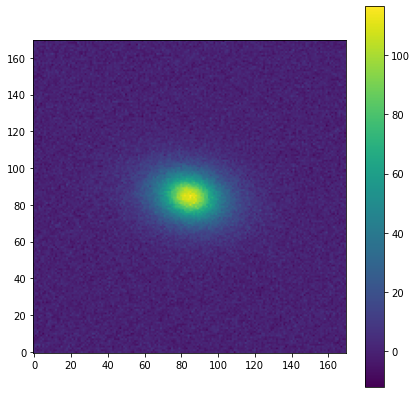

In [4]:
im = image.array
plt.imshow(im, origin='lower')
plt.colorbar()
plt.gcf().set_size_inches(7,7)

In [ ]:
## 

## Adding Gravitational Lensing

In weak gravitational lensing measurements, we care about detecting the distortion in galaxy shapes due to traveling through curved space (from local mass overdensities like galaxy clusters). But galaxies already have intrinsic shapes which makes this difficult (called shape noise). Let's try to understand this problem a bit better: 

(help w/ understanding shape & shear definitions)

![](images/g1g2.png)

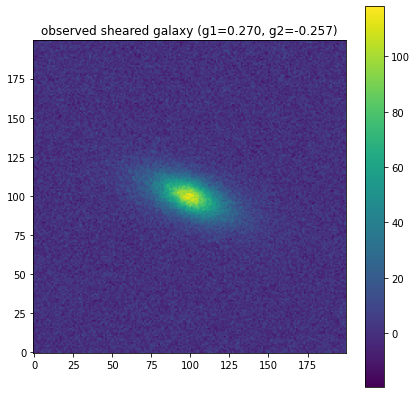

In [62]:
# Setup galaxy (most defaults are in arcsec if not specified)
gal = gs.Sersic(flux=1e5, n=1, half_light_radius=2)

# give it an intrinsic non-circular shape
g1_shape, g2_shape = 0.3, -0.25
gal = gal.shear(g1=g1_shape, g2=g2_shape) # this is to set the intrinsic shape, *not* the lensing shear!

# now pretend it has been lensed by a nearby galaxy cluster
# (Note that this shear is much smaller than the intrinsic shape, though i boosted it
# a bit for the demo)
g1_lens, g2_lens = 0.05, -0.075
sheared_gal = gal.shear(g1=g1_lens, g2=g2_lens)

# setup psf (PSF flux should always add to 1, also the default)
psf = gs.Moffat(beta=5, flux=1., half_light_radius=0.75) # more realistic

# an observed galaxy will be the convolution of the galaxy's intrinsic light profile 
# with the PSF and camera pixels (pixel convolution happens later)
obs_gal = gs.Convolve([sheared_gal, psf])

# draw image
pixel_scale = 0.141 # arcsec / pixel; this is SuperBIT's pixel scale!
image = obs_gal.drawImage(scale=pixel_scale, nx=200, ny=200)

# add some noise to the image
noise = gs.GaussianNoise(sigma=5)
image.addNoise(noise)

# let's estimate the image shape:
psf_im = psf.drawImage(scale=pixel_scale, nx=200, ny=200)
hsm_results = gs.hsm.EstimateShear(image, psf_im)
meas_shape = hsm_results.observed_shape

plt.imshow(image.array, origin='lower')
plt.colorbar()
plt.title(f'observed sheared galaxy (g1={meas_shape.g1:.3f}, g2={meas_shape.g2:.3f})')
plt.gcf().set_size_inches(7,7)

Let's break down the estimated shape at various stages:

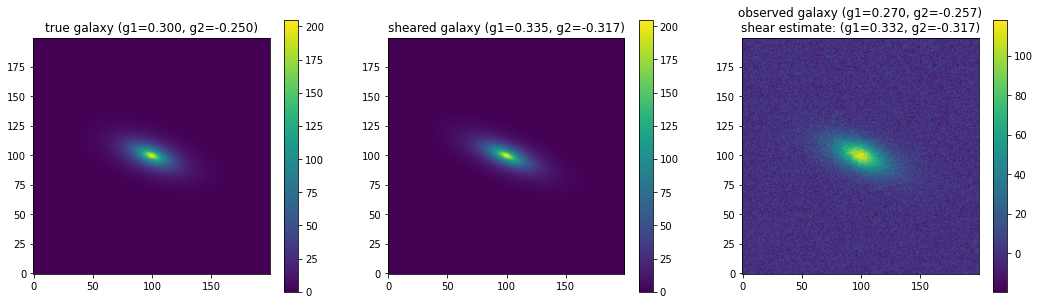

In [63]:
true_gal_im = gal.drawImage(scale=pixel_scale, nx=200, ny=200)
true_meas_shape = gs.hsm.EstimateShear(true_gal_im, psf_im).observed_shape

true_sheared_gal_im = sheared_gal.drawImage(scale=pixel_scale, nx=200, ny=200)
true_sheared_meas_shape = gs.hsm.EstimateShear(true_sheared_gal_im, psf_im).observed_shape

plt.subplot(131)
plt.imshow(true_gal_im.array, origin='lower')
plt.colorbar()
plt.title(f'true galaxy (g1={true_meas_shape.g1:.3f}, g2={true_meas_shape.g2:.3f})')

plt.subplot(132)
plt.imshow(true_sheared_gal_im.array, origin='lower')
plt.colorbar()
plt.title(f'sheared galaxy (g1={true_sheared_meas_shape.g1:.3f}, g2={true_sheared_meas_shape.g2:.3f})')

plt.subplot(133)
plt.imshow(image.array, origin='lower')
plt.colorbar()
est_e1 = hsm_results.corrected_e1
est_e2 = hsm_results.corrected_e2
est_shear = gs.Shear(e1=est_e1, e2=est_e2)
est_g1, est_g2 = est_shear.g1, est_shear.g2
plt.title(f'observed galaxy (g1={meas_shape.g1:.3f}, g2={meas_shape.g2:.3f})\n' +\
         f'shear estimate: (g1={est_g1:.3f}, g2={est_g2:.3f})')

plt.gcf().set_size_inches(18,5)

Notice that our shape estimate is very good due having a perfect PSF model to deconvolve with; this isn't necessarily the case in real data! Also, it's not perfect - why?.

Not only do we need to calibrate these effects, but even if we had a perfect estimate, we have no way of knowing how much came from intrinsic shape vs. the actual lensing! That is why we need to average the shapes of _lots_ of nearby galaxies together to estimate the local shear

In [ ]:
Ok, let's finish up by learning another useful astronomy software tool for 